## Imports

In [138]:
from numpy.lib import median
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import accuracy_score
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from aeon.distances import dtw_distance, euclidean_distance
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from aeon.transformations.collection import PaddingTransformer
from aeon.classification.feature_based import Catch22Classifier
from sklearn.ensemble import RandomForestClassifier
from aeon.testing.data_generation import make_example_3d_numpy
from aeon.classification.deep_learning import TimeCNNClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## Carga da base

In [140]:
df_total = pd.DataFrame()
for i in os.listdir('normalizacao/'):
    df = pd.read_excel(f"normalizacao/{i}",header=None)
    df['Nome'] = i.split('-')[1].split('.')[0]
    df_total = pd.concat([df,df_total])
df_total = df_total.rename(columns={1:'Qtd Total Pontos',2:'Qtd Dados'})

In [141]:
df_total['Fadiga'] = [0 if x == 'Normal' else 1 for x in df_total[0]]
df_total

,0,Qtd Total Pontos,Qtd Dados,3,4,5,6,7,8,9,...,6998,6999,7000,7001,7002,7003,7004,7005,7006,Fadiga
0,Normal,209,209,567.446533,568.821289,566.604553,569.215271,567.596497,568.547424,566.788452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Normal,300,300,879.816956,879.942139,879.928650,879.803467,879.663269,879.543823,879.566345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Platô,2836,2833,572.095398,572.401611,571.013062,572.802307,570.430603,573.321533,570.844543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Normal,232,232,870.932861,870.796021,870.880981,870.852600,870.916504,870.940430,871.018433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Normal,243,243,565.241333,567.252869,565.120483,567.405396,565.388672,567.268066,565.052429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Normal,195,195,582.270752,582.312927,582.332642,582.324463,582.339294,582.328979,582.372803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
233,Normal,204,204,823.033081,822.782959,822.402832,822.113342,821.986511,822.004822,821.789124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
234,Normal,202,201,581.130737,581.057129,581.105042,581.154541,581.246277,581.339111,581.391541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
235,Normal,226,224,821.867798,821.840637,821.707642,821.677490,821.820312,821.877625,821.798767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Pipeline de Tratamentos

In [143]:
def pipeline_knn(df_total, seed, sampler = 'Under'):
    #Separar em Treino e Teste
    #12 treino 6 teste
    X = df_total.drop([0,'Fadiga','Qtd Dados','%De N Vazios'], axis=1)
    y = df_total[['Fadiga','Nome']]

    aleatorio = np.random.default_rng(seed = seed)
    nome_treino = aleatorio.choice(np.unique(df_total['Nome']), size=12, replace=False)
    nome_test = set(np.unique(df_total['Nome'])).difference(nome_treino)
    print(f'Pessoas Treino: {nome_treino}')
    print(f'Pessoas Teste: {np.array(nome_test)}')

    train_data = X[X['Nome'].isin(nome_treino)].drop(['Nome'],axis=1)
    train_labels = y[y['Nome'].isin(nome_treino)]['Fadiga']
    test_data = X[X['Nome'].isin(nome_test)].drop(['Nome'],axis=1)
    test_labels = y[y['Nome'].isin(nome_test)]['Fadiga']
    # random_seed = 40
    # train_data, test_data, train_labels, test_labels = train_test_split(X.drop(['Nome'], axis=1), y['Fadiga'],
    #                        train_size=0.7,
    #                        test_size=0.3,
    #                        random_state=random_seed)
    
    # #Porção do treinamento fica para validação (70-30)
    # train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels,
    #                        train_size=0.7,
    #                        test_size=0.3,
    #                        random_state=random_seed)

    
    print(f'Quantidade Treino: {len(train_data)}')
    print(f'Quantidade Teste: {len(test_data)}')

    #Balanceamento de Dados
    train_data.columns = train_data.columns.astype(str)
    print(train_labels.value_counts())
    if sampler == 'Under':
        rus = RandomUnderSampler()
    elif sampler == 'Over':
        rus = RandomOverSampler()
    train_data_re, train_labels_re = rus.fit_resample(train_data, train_labels)
    #train_data_re, train_labels_re = train_data, train_labels
    
    print(train_labels_re.value_counts())
    
    segmentos_treino = []
    train_qtd = train_data_re['Qtd Total Pontos'].values
    count = 0
    for linha in train_data_re.drop(['Qtd Total Pontos'],axis=1).values:
        serie = linha[:train_qtd[count]]
        serie = pd.Series(serie).interpolate().to_numpy()
        if pd.isna(serie[0]):
            serie = serie[1:]
        segmentos_treino.append(serie)
        count += 1
    segmentos_test = []
    test_qtd = test_data['Qtd Total Pontos'].values
    count = 0
    for linha in test_data.drop(['Qtd Total Pontos'],axis=1).values:
        serie = linha[:test_qtd[count]]
        serie = pd.Series(serie).interpolate().to_numpy()
        if pd.isna(serie[0]):
            serie = serie[1:]
        segmentos_test.append(serie)
        count += 1
    return segmentos_treino, train_labels_re.values, segmentos_test, test_labels.values

In [144]:
def pipeline_outros(df_total, seed, sampler = 'Under'):
    #Separar em Treino e Teste
    #12 treino 6 teste
    X = df_total.drop([0,'Fadiga'], axis=1)
    y = df_total[['Fadiga','Nome']]

    aleatorio = np.random.default_rng(seed = seed)
    nome_treino = aleatorio.choice(np.unique(df_total['Nome']), size=12, replace=False)
    nome_test = set(np.unique(df_total['Nome'])).difference(nome_treino)
    print(f'Pessoas Treino: {nome_treino}')
    print(f'Pessoas Teste: {np.array(nome_test)}')

    train_data = X[X['Nome'].isin(nome_treino)].drop(['Nome'],axis=1)
    train_labels = y[y['Nome'].isin(nome_treino)].drop(['Nome'],axis=1)
    test_data = X[X['Nome'].isin(nome_test)].drop(['Nome'],axis=1)
    test_labels = y[y['Nome'].isin(nome_test)].drop(['Nome'],axis=1)
    
    print(f'Quantidade Treino: {len(train_data)}')
    print(f'Quantidade Teste: {len(test_data)}')

    #Balanceamento de Dados

    print(train_labels['Fadiga'].value_counts())
    if sampler == 'Under':
        rus = RandomUnderSampler()
    elif sampler == 'Over':
        rus = RandomOverSampler()
    train_data_re, train_labels_re = rus.fit_resample(train_data, train_labels)
    
    print(train_labels_re['Fadiga'].value_counts())

    #Igualar Tamanhos
    padder = PaddingTransformer(pad_length=200, fill_value =0)
    segmento_x2 = padder.fit_transform(train_data_re)
    
    return segmento_x2, train_labels_re['Fadiga'], test_data, test_labels['Fadiga']

In [145]:
def test_uma_pessoa (df):
    segmentos = []
    train_qtd = df['Qtd Total Pontos'].values
    count = 0
    for linha in df.drop([0,'Fadiga','Nome','Qtd Dados','Qtd Total Pontos','%De N Vazios'],axis=1).values:
        serie = linha[:train_qtd[count]]
        serie = pd.Series(serie).interpolate().to_numpy()
        if pd.isna(serie[0]):
            serie = serie[1:]
        segmentos.append(serie)
        count += 1
    labels = df['Fadiga']
    return segmentos, labels.values

Filtro Baseado na Analise

In [147]:
df_total['%De N Vazios'] = df_total['Qtd Dados'] / df_total['Qtd Total Pontos']
df_filtrado = df_total[(df_total['%De N Vazios'] > 0.85) 
    & (df_total[0] != 'Erro na Coleta') 
    & ((df_total['Qtd Total Pontos'] < 500) | (df_total[0] == 'Platô'))  
    & (df_total['Qtd Total Pontos'] < 1000)
    & (df_total['Nome'] != 'Josefina')
]

In [148]:
teste =df_total.groupby(['Nome'])['Fadiga'].value_counts()

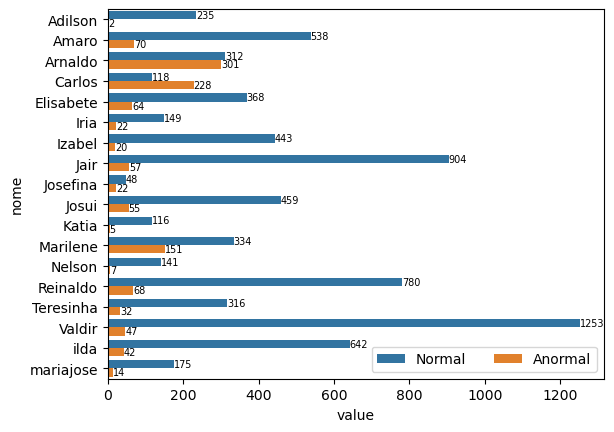

In [149]:
teste =df_total.groupby(['Nome'])['Fadiga'].value_counts()
nome = []
classe = []
for i in teste.index:
    nome.append(i[0])
    if i[1] == 1:
        classe.append('Anormal')
    else:
        classe.append('Normal')
df_teste = pd.DataFrame({'value':teste.values,'nome':nome,'classe':classe})
ax = sns.barplot(df_teste,x='value',y='nome',hue='classe')
ax.bar_label(ax.containers[0], fontsize=7);
ax.bar_label(ax.containers[1], fontsize=7);
ax.legend(ncol=2, loc="lower right", frameon=True)

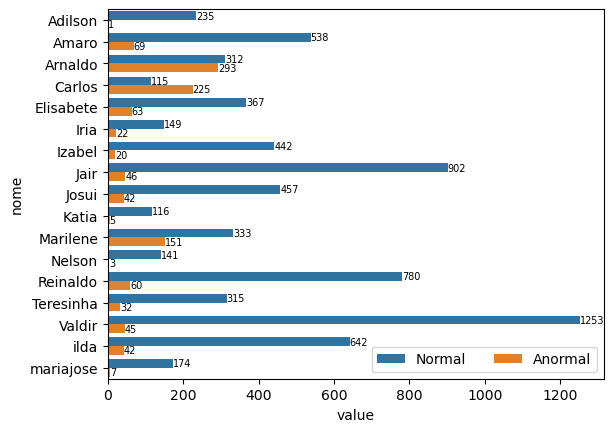

In [150]:
teste = df_filtrado.groupby(['Nome'])['Fadiga'].value_counts()
nome = []
classe = []
for i in teste.index:
    nome.append(i[0])
    if i[1] == 1:
        classe.append('Anormal')
    else:
        classe.append('Normal')
df_teste = pd.DataFrame({'value':teste.values,'nome':nome,'classe':classe})
#f, ax = plt.subplots(figsize=(6, 15))
ax = sns.barplot(df_teste,x='value',y='nome',hue='classe')
ax.bar_label(ax.containers[0], fontsize=7);
ax.bar_label(ax.containers[1], fontsize=7);
ax.legend(ncol=2, loc="lower right", frameon=True)

## Decidindo melhor Treino e Test utilizando KNN

In [168]:
melhor_pre = [0.0,0.0]
melhor_seed = 0
for seed in range(100):
    train_data, train_labels, test_data, test_labels = pipeline_knn(df_filtrado,seed = seed,sampler = 'Under')
    train_data_x = []
    for i in train_data:
        train_data_x.append(np.array(i).reshape(1,len(i)))
    test_data_x = []
    for i in test_data:
        test_data_x.append(np.array(i).reshape(1,len(i)))
    train_labels_y = np.array(train_labels)
    test_labels_y = np.array(test_labels)
    clf = Catch22Classifier(
    estimator = KNeighborsTimeSeriesClassifier(distance=dtw_distance, n_neighbors = 5), #RandomForestClassifier(n_estimators=100),
        replace_nans=True,
        outlier_norm=True,
        random_state=0,
    )
    clf.fit(train_data_x, train_labels_y)
    predicts = clf.predict(test_data_x)
    rep = classification_report(test_labels,predicts,output_dict = True)
    if(melhor_pre[0] < rep['0']['precision'] and melhor_pre[1] < rep['1']['precision']):
        melhor_pre[0] = rep['0']['precision']
        melhor_pre[1] = rep['1']['precision']
        melhor_seed = seed

Pessoas Treino: ['Iria' 'Reinaldo' 'Jair' 'Elisabete' 'Carlos' 'Teresinha' 'Arnaldo'
 'Adilson' 'Marilene' 'Valdir' 'ilda' 'Nelson']
Pessoas Teste: {'Katia', 'mariajose', 'Josui', 'Izabel', 'Amaro'}
Quantidade Treino: 6527
Quantidade Teste: 1870
Fadiga
0    5544
1     983
Name: count, dtype: int64
Fadiga
0    983
1    983
Name: count, dtype: int64
Pessoas Treino: ['Adilson' 'Carlos' 'ilda' 'Katia' 'Reinaldo' 'Arnaldo' 'Teresinha'
 'Amaro' 'Jair' 'Izabel' 'Elisabete' 'Josui']
Pessoas Teste: {'mariajose', 'Marilene', 'Nelson', 'Valdir', 'Iria'}
Quantidade Treino: 6119
Quantidade Teste: 2278
Fadiga
0    5221
1     898
Name: count, dtype: int64
Fadiga
0    898
1    898
Name: count, dtype: int64
Pessoas Treino: ['ilda' 'Katia' 'Reinaldo' 'Josui' 'Arnaldo' 'Nelson' 'Amaro' 'Elisabete'
 'Iria' 'Teresinha' 'Adilson' 'mariajose']
Pessoas Teste: {'Carlos', 'Marilene', 'Valdir', 'Jair', 'Izabel'}
Quantidade Treino: 4865
Quantidade Teste: 3532
Fadiga
0    4226
1     639
Name: count, dtype: int64
F

In [172]:
print(melhor_pre)
print(melhor_seed)
train_data, train_labels, test_data, test_labels = pipeline_knn(df_filtrado,seed = melhor_seed,sampler = 'Under')

[0.9491255961844197, 0.07933884297520662]
20
Pessoas Treino: ['Elisabete' 'mariajose' 'ilda' 'Valdir' 'Arnaldo' 'Marilene' 'Josui'
 'Izabel' 'Carlos' 'Nelson' 'Amaro' 'Iria']
Pessoas Teste: {'Katia', 'Reinaldo', 'Teresinha', 'Adilson', 'Jair'}
Quantidade Treino: 5905
Quantidade Teste: 2492
Fadiga
0    4923
1     982
Name: count, dtype: int64
Fadiga
0    982
1    982
Name: count, dtype: int64


## KNN com Catch 22

In [174]:
train_data, train_labels, test_data, test_labels = pipeline_knn(df_filtrado,seed = melhor_seed,sampler = 'Under')

train_data_x = []
for i in train_data:
    train_data_x.append(np.array(i).reshape(1,len(i)))
test_data_x = []
for i in test_data:
    test_data_x.append(np.array(i).reshape(1,len(i)))
train_labels_y = np.array(train_labels)
test_labels_y = np.array(test_labels)

Pessoas Treino: ['Elisabete' 'mariajose' 'ilda' 'Valdir' 'Arnaldo' 'Marilene' 'Josui'
 'Izabel' 'Carlos' 'Nelson' 'Amaro' 'Iria']
Pessoas Teste: {'Katia', 'Reinaldo', 'Teresinha', 'Adilson', 'Jair'}
Quantidade Treino: 5905
Quantidade Teste: 2492
Fadiga
0    4923
1     982
Name: count, dtype: int64
Fadiga
0    982
1    982
Name: count, dtype: int64


In [175]:
clf = Catch22Classifier(
    estimator = KNeighborsTimeSeriesClassifier(distance=dtw_distance, n_neighbors = 5), #RandomForestClassifier(n_estimators=100),
    replace_nans=True,
    outlier_norm=True,
    random_state=0,
)
clf.fit(train_data_x, train_labels_y)

Catch22Classifier(estimator=KNeighborsTimeSeriesClassifier(distance=CPUDispatcher(<function dtw_distance at 0x000001C1B7369800>),
                                                           n_neighbors=5),
                  outlier_norm=True, random_state=0)

In [176]:
predicts = clf.predict(test_data_x)

acc = accuracy_score(test_labels,predicts)
print(acc)

0.7700642054574639


In [177]:
print(classification_report(test_labels,predicts))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      2348
           1       0.08      0.28      0.13       144

    accuracy                           0.77      2492
   macro avg       0.51      0.54      0.50      2492
weighted avg       0.90      0.77      0.82      2492



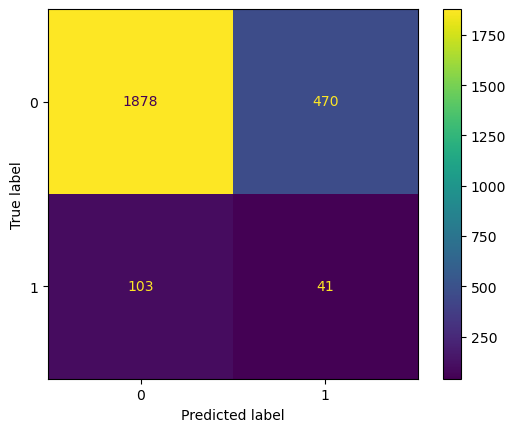

In [179]:
disp = ConfusionMatrixDisplay.from_predictions(test_labels,predicts)

### Classificação de 1 pessoa

In [184]:
pessoa, labels = test_uma_pessoa(df_filtrado[df_filtrado['Nome'] == 'Teresinha'])
pessoa_x = []
for i in pessoa:
    pessoa_x.append(np.array(i).reshape(1,len(i)))
labels_y = np.array(labels)

In [186]:
predicts = clf.predict(pessoa_x)

acc = accuracy_score(labels_y,predicts)
print(acc)

0.5331412103746398


In [187]:
print(classification_report(labels_y,predicts))

              precision    recall  f1-score   support

           0       0.93      0.52      0.67       315
           1       0.12      0.62      0.20        32

    accuracy                           0.53       347
   macro avg       0.52      0.57      0.43       347
weighted avg       0.86      0.53      0.63       347



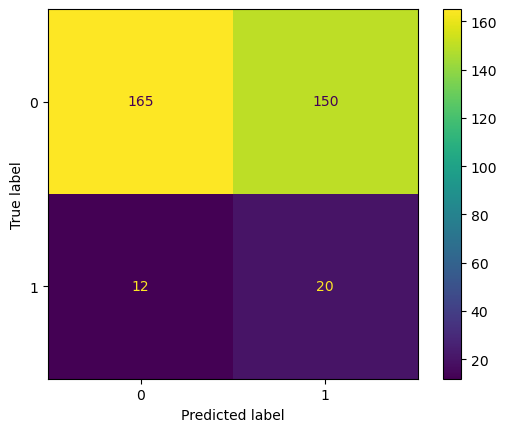

In [188]:
disp = ConfusionMatrixDisplay.from_predictions(labels_y,predicts)

In [192]:
y = 0
count = 0
column_y = []
column_x = []
label = []
for serie in pessoa_x:
    for line in serie:
        for x in line:
            if labels_y[count] == 1 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(x)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(x)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(x)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 1 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(x)
                label.append('FN')

            y += 1
        count += 1 
teste_df = pd.DataFrame({'x':column_x,'y':column_y,'label':label})


In [194]:
teste_df.to_excel("resultados\Teresinha.xlsx", index=False)

### KNN melhor parametros

In [195]:
train_data, train_labels, test_data, test_labels = pipeline_knn(df_filtrado,seed = melhor_seed,sampler = 'Under')

train_data_x = []
for i in train_data:
    train_data_x.append(np.array(i).reshape(1,len(i)))
test_data_x = []
for i in test_data:
    test_data_x.append(np.array(i).reshape(1,len(i)))
train_labels_y = np.array(train_labels)
test_labels_y = np.array(test_labels)

Pessoas Treino: ['Elisabete' 'mariajose' 'ilda' 'Valdir' 'Arnaldo' 'Marilene' 'Josui'
 'Izabel' 'Carlos' 'Nelson' 'Amaro' 'Iria']
Pessoas Teste: {'Katia', 'Reinaldo', 'Teresinha', 'Adilson', 'Jair'}
Quantidade Treino: 5905
Quantidade Teste: 2492
Fadiga
0    4923
1     982
Name: count, dtype: int64
Fadiga
0    982
1    982
Name: count, dtype: int64


In [237]:
melhor_acc_knn = 0.0
melhor_parm_k = 0
melhor_parm_knn = [0,'']
distances = ['euclidean','squared','manhattan','minkowski','dtw']
for dist in distances:
    for k in range(1,25):
        clf = Catch22Classifier(
        estimator = KNeighborsTimeSeriesClassifier(distance=dist, n_neighbors = k), #RandomForestClassifier(n_estimators=100),
            replace_nans=True,
            outlier_norm=True,
            random_state=0,
        )
        clf.fit(train_data_x, train_labels_y)
        predicts = clf.predict(test_data_x)
        acc = accuracy_score(test_labels,predicts)
        print(f'Distance: {dist}, k: {k} Acuracy:{acc}')
        if(melhor_acc_knn < acc):
            melhor_acc = acc
            melhor_parm_knn[0] = k
            melhor_parm_knn[1] = dist

Distance: euclidean, k: 1 Acuracy:0.6845906902086677
Distance: euclidean, k: 2 Acuracy:0.841091492776886
Distance: euclidean, k: 3 Acuracy:0.7504012841091493
Distance: euclidean, k: 4 Acuracy:0.8378812199036918
Distance: euclidean, k: 5 Acuracy:0.7564205457463884
Distance: euclidean, k: 6 Acuracy:0.8459069020866774
Distance: euclidean, k: 7 Acuracy:0.790529695024077
Distance: euclidean, k: 8 Acuracy:0.8418940609951846
Distance: euclidean, k: 9 Acuracy:0.8021669341894061
Distance: euclidean, k: 10 Acuracy:0.8531300160513644
Distance: euclidean, k: 11 Acuracy:0.8378812199036918
Distance: euclidean, k: 12 Acuracy:0.8611556982343499
Distance: euclidean, k: 13 Acuracy:0.8406902086677368
Distance: euclidean, k: 14 Acuracy:0.8667736757624398
Distance: euclidean, k: 15 Acuracy:0.8563402889245586
Distance: euclidean, k: 16 Acuracy:0.8675762439807384
Distance: euclidean, k: 17 Acuracy:0.8591492776886035
Distance: euclidean, k: 18 Acuracy:0.8703852327447833
Distance: euclidean, k: 19 Acuracy:0.86

In [238]:
print(melhor_acc_knn)
print(melhor_parm_knn)

0.0
[24, 'dtw']


In [261]:
clf = Catch22Classifier(
estimator = KNeighborsTimeSeriesClassifier(distance=melhor_parm_knn[1], n_neighbors = melhor_parm_knn[0]), #RandomForestClassifier(n_estimators=100),
    replace_nans=True,
    outlier_norm=True,
    random_state=0,
)
clf.fit(train_data_x, train_labels_y)
predicts = clf.predict(test_data_x)
acc = accuracy_score(test_labels,predicts)

In [240]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,predicts))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2348
           1       0.11      0.16      0.13       144

    accuracy                           0.87      2492
   macro avg       0.53      0.54      0.53      2492
weighted avg       0.90      0.87      0.89      2492



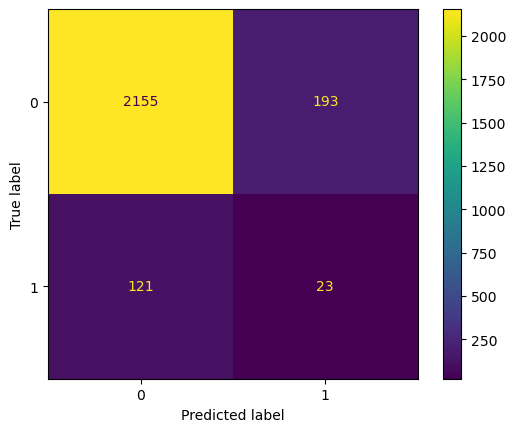

In [242]:
disp = ConfusionMatrixDisplay.from_predictions(test_labels,predicts)

### Visualização 1 pessoa

In [262]:
pessoa, labels = test_uma_pessoa(df_filtrado[df_filtrado['Nome'] == 'Teresinha'])
pessoa_x = []
for i in pessoa:
    pessoa_x.append(np.array(i).reshape(1,len(i)))
labels_y = np.array(labels)

In [263]:
predicts = clf.predict(pessoa_x)

acc = accuracy_score(labels_y,predicts)
print(acc)

0.654178674351585


In [264]:
print(classification_report(labels_y,predicts))

              precision    recall  f1-score   support

           0       0.91      0.69      0.78       315
           1       0.10      0.34      0.15        32

    accuracy                           0.65       347
   macro avg       0.51      0.51      0.47       347
weighted avg       0.84      0.65      0.72       347



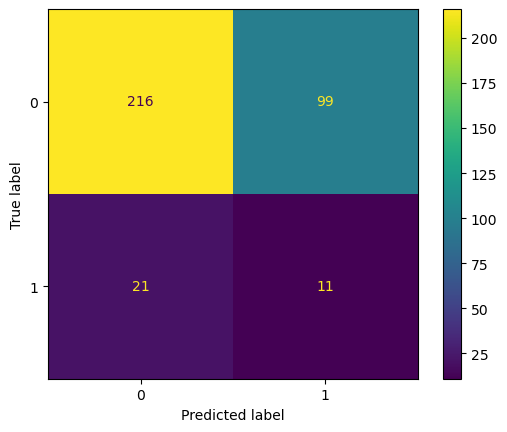

In [265]:
disp = ConfusionMatrixDisplay.from_predictions(labels_y,predicts)

In [266]:
y = 0
count = 0
column_y = []
column_x = []
label = []
for serie in pessoa_x:
    for line in serie:
        for x in line:
            if labels_y[count] == 1 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(x)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(x)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(x)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 1 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(x)
                label.append('FN')

            y += 1
        count += 1 
teste_df = pd.DataFrame({'x':column_x,'y':column_y,'label':label})

In [267]:
teste_df.to_excel("resultados\Teresinha_knn.xlsx", index=False)

## Random Forest

In [243]:
train_data, train_labels, test_data, test_labels = pipeline_knn(df_filtrado,seed = melhor_seed,sampler = 'Under')

train_data_x = []
for i in train_data:
    train_data_x.append(np.array(i).reshape(1,len(i)))
test_data_x = []
for i in test_data:
    test_data_x.append(np.array(i).reshape(1,len(i)))
train_labels_y = np.array(train_labels)
test_labels_y = np.array(test_labels)

Pessoas Treino: ['Elisabete' 'mariajose' 'ilda' 'Valdir' 'Arnaldo' 'Marilene' 'Josui'
 'Izabel' 'Carlos' 'Nelson' 'Amaro' 'Iria']
Pessoas Teste: {'Katia', 'Reinaldo', 'Teresinha', 'Adilson', 'Jair'}
Quantidade Treino: 5905
Quantidade Teste: 2492
Fadiga
0    4923
1     982
Name: count, dtype: int64
Fadiga
0    982
1    982
Name: count, dtype: int64


In [250]:
melhor_acc_tree = 0.0
melhor_parm_tree = 0
for tree in range(1,200):
    clf = Catch22Classifier(
    estimator = RandomForestClassifier(n_estimators = tree), #RandomForestClassifier(n_estimators=100),
        replace_nans=True,
        outlier_norm=True,
        random_state=0,
    )
    clf.fit(train_data_x, train_labels_y)
    predicts = clf.predict(test_data_x)
    acc = accuracy_score(test_labels,predicts)
    print(f'Trees:{tree} Acuracy:{acc}')
    if(melhor_acc_tree < acc):
        melhor_acc_tree = acc
        melhor_parm_tree = tree
        

Trees:1 Acuracy:0.7447833065810594
Trees:2 Acuracy:0.8756019261637239
Trees:3 Acuracy:0.8174157303370787
Trees:4 Acuracy:0.8691813804173355
Trees:5 Acuracy:0.819422150882825
Trees:6 Acuracy:0.8647672552166934
Trees:7 Acuracy:0.8290529695024077
Trees:8 Acuracy:0.8671749598715891
Trees:9 Acuracy:0.8322632423756019
Trees:10 Acuracy:0.8523274478330658
Trees:11 Acuracy:0.836677367576244
Trees:12 Acuracy:0.8579454253611557
Trees:13 Acuracy:0.8362760834670947
Trees:14 Acuracy:0.8615569823434992
Trees:15 Acuracy:0.843900481540931
Trees:16 Acuracy:0.8599518459069021
Trees:17 Acuracy:0.8398876404494382
Trees:18 Acuracy:0.8571428571428571
Trees:19 Acuracy:0.8350722311396469
Trees:20 Acuracy:0.8539325842696629
Trees:21 Acuracy:0.8451043338683788
Trees:22 Acuracy:0.858346709470305
Trees:23 Acuracy:0.8455056179775281
Trees:24 Acuracy:0.8527287319422151
Trees:25 Acuracy:0.8414927768860353
Trees:26 Acuracy:0.8527287319422151
Trees:27 Acuracy:0.8386837881219904
Trees:28 Acuracy:0.8503210272873194
Trees

In [251]:
print(melhor_acc_tree)
print(melhor_parm_tree)

0.8756019261637239
2


In [302]:
clf = Catch22Classifier(
estimator = RandomForestClassifier(n_estimators = melhor_parm_tree), #RandomForestClassifier(n_estimators=100),
    replace_nans=True,
    outlier_norm=True,
    random_state=0,
)
clf.fit(train_data_x, train_labels_y)
predicts = clf.predict(test_data_x)
acc = accuracy_score(test_labels,predicts)

In [303]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,predicts))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2348
           1       0.18      0.31      0.23       144

    accuracy                           0.88      2492
   macro avg       0.57      0.61      0.58      2492
weighted avg       0.91      0.88      0.89      2492



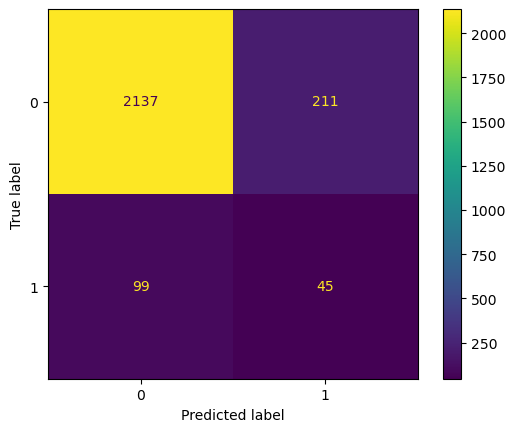

In [304]:
disp = ConfusionMatrixDisplay.from_predictions(test_labels,predicts)

### Uma Pessoa Random Forest

In [278]:
pessoa, labels = test_uma_pessoa(df_filtrado[df_filtrado['Nome'] == 'Teresinha'])
pessoa_x = []
for i in pessoa:
    pessoa_x.append(np.array(i).reshape(1,len(i)))
labels_y = np.array(labels)

In [280]:
predicts = clf.predict(pessoa_x)

acc = accuracy_score(labels_y,predicts)
print(acc)

0.7694524495677233


In [282]:
print(classification_report(labels_y,predicts))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       315
           1       0.11      0.22      0.15        32

    accuracy                           0.77       347
   macro avg       0.51      0.52      0.51       347
weighted avg       0.84      0.77      0.80       347



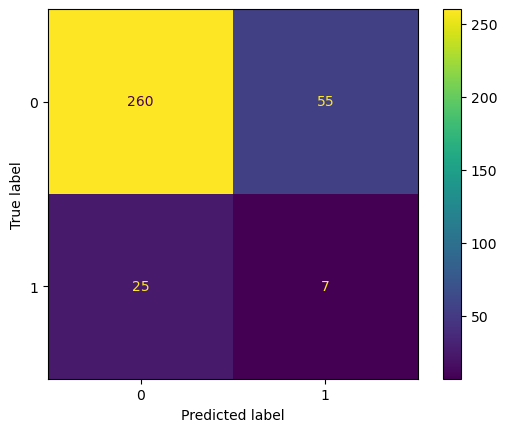

In [284]:
disp = ConfusionMatrixDisplay.from_predictions(labels_y,predicts)

In [286]:
y = 0
count = 0
column_y = []
column_x = []
label = []
for serie in pessoa_x:
    for line in serie:
        for x in line:
            if labels_y[count] == 1 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(x)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(x)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 0 and predicts[count] == 1:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(x)
                label.append('FP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FN')
            if labels_y[count] == 1 and predicts[count] == 0:
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TP')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('TN')
                column_y.append(y)
                column_x.append(np.nan)
                label.append('FP')
                column_y.append(y)
                column_x.append(x)
                label.append('FN')

            y += 1
        count += 1 
teste_df = pd.DataFrame({'x':column_x,'y':column_y,'label':label})

In [288]:
teste_df.to_excel("resultados\Teresinha_rf.xlsx", index=False)

## CNN

In [ ]:
from aeon.classification.deep_learning import TimeCNNClassifier
classifier = TimeCNNClassifier(n_epochs=20, batch_size=4)
classifier.fit(train_data, train_labels)

In [ ]:
#computa as classes para todos
predicts = classifier.predict(test_data)

from sklearn.metrics import accuracy_score
acc = accuracy_score(test_labels,predicts)
print(acc)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,predicts))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(test_labels, predicts)